In [119]:
import re
import pandas as pd
from new_env import *
import json
import pickle

In [120]:
from torch_geometric.loader import DataLoader

In [121]:
with open("gnn_induct_agent_replays.json") as f:
    gnn_reps = json.load(f)

In [122]:
with open("vanilla_agent_replays.json") as f:
    vanilla_reps = json.load(f)

In [123]:
with open("transformer_agent_replays.json") as f:
    transformer_reps = json.load(f)

In [124]:
with open("include_probability.json") as f:
    db = json.load(f)

reverse_database = {(value[0], value[1]) : key for key, value in db.items()}


In [125]:
hists = [gnn_reps[key][1] for key in gnn_reps.keys()]

In [126]:
def hist_to_tacs(hist):
    tacs = [step['by_tactic'] for step in hist if step['by_tactic'] != '']
    return tacs

In [127]:
def hist_valid(hist):
    goal = hist[0]['content'][0]['polished']['goal']
    db[goal]
    allowed_theories = list(set(re.findall(r'C\$(\w+)\$ ', goal)))
    #allowed_theories = [th + "Theory" for th in allowed_theories if th != "min"]
    goal_theory = db[goal][0]
    # print (db[goal])
    # print (goal_theory)
    tacs = hist_to_tacs(hist)
    goal_th_args = []
    # print (tacs)
    for tac in tacs:
        if goal_theory in tac:
            args = tac.split(goal_theory + "Theory")[1:]
            for arg in args:
                if "," in arg:
                    goal_th_args.append(arg.split(",")[0][1:])

                else:
                    goal_th_args.append(arg[1:][:-1])

    errs = 0
    wtfs = 0
    count = 0
    print (goal_th_args, tacs, goal, db[goal])
    for arg in goal_th_args:
        for key, value in db.items():
            if db[key][1] == arg and db[key][0] == goal_theory:
                # print (db[key])
                count += 1
                #ensure there's no invalid arguments
                print (arg, db[goal], db[key])
                if int(db[key][2]) >= int(db[goal][2]) and db[key][0] == goal_theory:
                    wtfs += 1
    #                 print (db[goal])
    #                 print (allowed_theories)
    #                 print (tacs)

    if count != len(goal_th_args):
        # print (count, len(goal_th_args))
        errs += 1
        try:
            [reverse_database[(goal_theory, arg)] for arg in goal_th_args]
            print ("Count error")
            print (count, len(goal_th_args))
            print (count < len(goal_th_args))
        except:
            print ("cant find...")
            print (tacs, db[goal])

        # print (tacs)
        # print (db[goal])
    return goal_th_args, errs, wtfs

In [457]:
#check whether history from replays forms valid proofs (check the arguments are valid)
# e = 0
# w = 0
# for hist in hists:
#     args, errs, wtfs = hist_valid(hist)
#     e += errs
#     w += wtfs



In [458]:
# e (number of count errors) is nonzero, so some arguments can't be found in the database (only a few cases of this though) e.g. below

In [2]:
# No "EVERY2_APPEND" argument even though it's found in the replay
# for key, value in db.items():
#     if value[0] == "rich_list":
#         print (value)for key, value in db.items():
#     if value[1] == "EVERY2_APPEND":
#         print (value)

In [3]:
# vanilla_hists = [vanilla_reps[key][1] for key in vanilla_reps.keys()]
# e = 0
# w = 0
# for hist in vanilla_hists:
#     args, errs, wtfs = hist_valid(hist)
#     e += errs
#     w += wtfs

In [108]:
with open("traces/final/gnn_final_1040.pk", "rb") as f:
    gnn_proved = pickle.load(f)

with open("traces/final/vanilla_final_1009.pk", "rb") as f:
    vanilla_proved = pickle.load(f)

with open("traces/final/transformer_prove_count_1007_it.pk", "rb") as f:
    transformer_proved = pickle.load(f)


In [155]:
import pandas as pd

def plot_multiple_moving_averages(data_dict, title="Plot", window_size=20, dir=None):
    for label, data in data_dict.items():
        df = pd.DataFrame(data, columns=['values'])
        rolling_mean = df['values'].rolling(window=window_size).mean()
        rolling_std = df['values'].rolling(window=window_size).std()
        # plt.plot(df['values'], label=label)
        plt.plot(rolling_mean, label=f"{label}")# moving average")
        plt.fill_between(df.index, rolling_mean-rolling_std, rolling_mean+rolling_std, color='gray', alpha=0.2)#, label=f"{label} standard deviation")
    plt.legend()
    plt.title(title)
    plt.show()
    if dir:
        plt.savefig(title)

    return



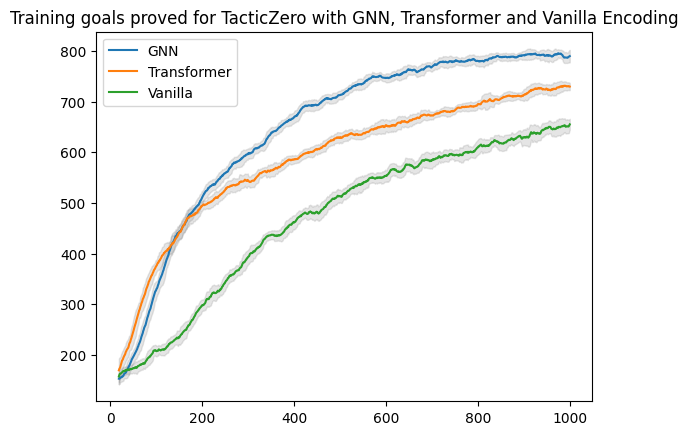

In [156]:
import matplotlib.pyplot as plt

data_dict = {"GNN": gnn_proved[:1000], "Transformer": transformer_proved[:1000], "Vanilla": vanilla_proved[:1000]}

plot_multiple_moving_averages(data_dict, title="Training goals proved for TacticZero with GNN, Transformer and Vanilla Encoding")


In [128]:
import numpy as np
# gnn_reps[list(gnn_reps.keys())[0]]

rep_lens = [rep[0] for rep in list(gnn_reps.values())]
rep_lens_vanilla = [rep[0] for rep in list(vanilla_reps.values())]
rep_lens_transformer = [rep[0] for rep in list(transformer_reps.values())]

In [129]:
# Vanilla cumulative proofs much closer to GNN/Transformer than with test set, which suggests it doesn't generalise as well to unseen goals and is "rote" learning
print (len(rep_lens), len(rep_lens_vanilla), len(rep_lens_transformer))


912 860 918


In [130]:
np.mean(rep_lens_vanilla)

2.2790697674418605

In [131]:
np.mean(rep_lens)

1.8607456140350878

In [132]:
np.mean(rep_lens_transformer)

2.326797385620915

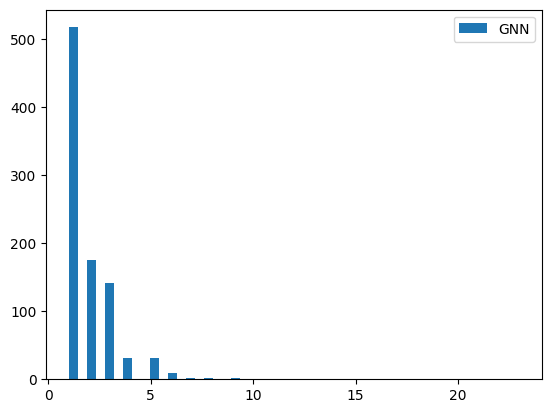

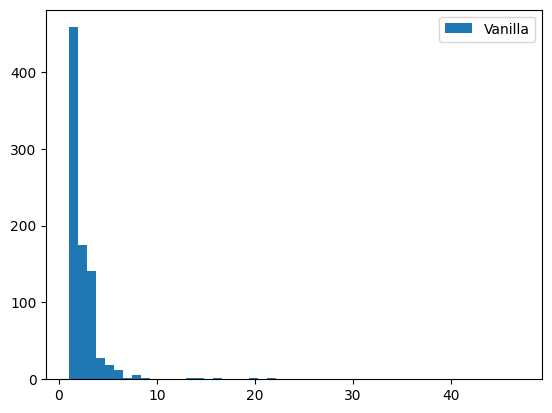

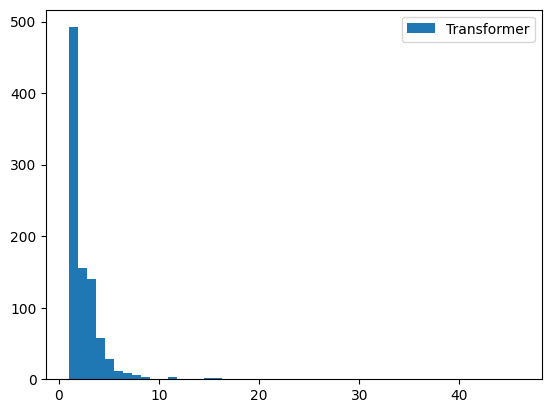

In [134]:
plt.hist(sorted(rep_lens), bins=50, label="GNN")
plt.plot()
plt.legend()
plt.show()
plt.hist(sorted(rep_lens_vanilla), bins=50, label="Vanilla")
plt.plot()
plt.legend()
plt.show()

plt.hist(sorted(rep_lens_transformer), bins=50, label="Transformer")
plt.plot()
plt.legend()
plt.show()

In [331]:
with open("pred_set_replays.json") as f:
    pred_set_replays_old = json.load(f)

In [330]:
with open("valid_goals_shuffled.pk", "rb") as f:
    valid_goals = pickle.load(f)

train_goals = valid_goals[:int(0.8 * len(valid_goals))]
test_goals = valid_goals[int(0.8 * len(valid_goals)):]


In [265]:
# check all proof replay are in the training goal set
# t = list(set([i[1][0]['content'][0]['polished']['goal'] for i in list(gnn_reps.values())]))
# count = 0
#
# for g in t:
#     if g in [goal[0] for goal in train_goals]:
#         count +=1
# assert count == len(gnn_reps)

In [440]:
# verify proof successes in HOL environment
# from new_env import *
# env = HolEnv("T")
#
# count = 0
# for rep in [h[1] for h in gnn_reps.values()]:
#     try:
#         goal = rep[0]["content"][0]["plain"]["goal"]
#         goal_th = db[plain_to_polished[goal]][0]
#         env.reset(goal)
#         env.toggle_simpset("diminish", goal_th)
#         if check_proof(env, rep):
#             count += 1
#     except Exception as e:
#         print("Restarting environment..")
#         env = HolEnv("T")
#         continue
#
# print (f"{count}/{len(gnn_reps.values())} proofs successfully recreated")

# 815 / 842, changes each run so could be e.g. timeout

In [303]:
# env = HolEnv("T")
#
# count = 0
# for rep in [h[1] for h in vanilla_reps.values()]:
#     try:
#         goal = rep[0]["content"][0]["plain"]["goal"]
#         env.reset(goal)
#         if check_proof(env, rep):
#             count += 1
#     except Exception as e:
#         # print("Restarting environment..")
#         env = HolEnv("T")
#         continue
#
# print (f"{count}/{len(vanilla_reps.values())} proofs successfully recreated")
#773/811

In [268]:
# plotting proof searches

# for key, value in gnn_reps.items():
#         if value[0] > 40:
#             print (value)
#             draw_tree(value[1])
#             break

In [292]:
# for key in unique_gnn_reps:
#         if gnn_reps[key][0] > 40:
#             print (value)
#             draw_tree(value[1])


# print (unique_gnn_reps[3])
# #pred_set_th pow_def
# #draw_tree(gnn_reps[list(unique_gnn_reps)[3]][1])
# print (gnn_reps[list(unique_gnn_reps)[3]][1])
# goal_polished = gnn_reps[list(unique_gnn_reps)[3]][1][0]['content'][0]['polished']['goal']

In [131]:

# test_hist = gnn_reps[list(unique_gnn_reps)[0]][1]
# # reconstruct_proof(test_hist)
# reconstruct_proof(test_hist).split(",")
#
# #get all arguments from proof history
# hist_args = re.findall(r'\[(.*?)]', reconstruct_proof(test_hist))
# hist_args_ = [i for j in range(0, len(hist_args)) for i in hist_args[j].replace(" ", "").split(",")]
# hist_args_set = set(hist_args_)
# print (len(hist_args_), len(set(hist_args_)))
# len(set(hist_args_))

In [293]:
# hist_args_set

In [294]:
# goal_polished

In [295]:
# pow_def_polished = ""
# for key, value in db.items():
#     if value[0] == "pred_set" and value[1] == "POW_DEF":
#         print (key)
#         pow_def_polished = key

In [464]:
import torch

In [465]:
encoder_premise_orig = torch.load("model_checkpoints/gnn_encoder_latest_premise")
encoder_goal_orig = torch.load("model_checkpoints/gnn_encoder_latest_goal")
encoder_premise_online = torch.load("model_checkpoints/gnn_encoder_premise_e2e")
encoder_goal_online = torch.load("model_checkpoints/gnn_encoder_goal_e2e")


In [466]:
from batch_predictor import BatchPredictor
from checkpoint import Checkpoint
checkpoint_path = "vanilla_enc_models/2021_02_22_16_07_03"  # 97-98% accuracy model, up to and include probability theory


checkpoint = Checkpoint.load(checkpoint_path)
seq2seq = checkpoint.model
input_vocab = checkpoint.input_vocab
output_vocab = checkpoint.output_vocab

vanilla_encoder = BatchPredictor(seq2seq, input_vocab, output_vocab)



/home/sean/Documents/venvs/torch_env/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning:

source code of class 'seq2seq.models.EncoderRNN.EncoderRNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.

/home/sean/Documents/venvs/torch_env/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning:

source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.

/home/sean/Documents/venvs/torch_env/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning:

source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or s

In [467]:
import ast_def

# graph_pow_def = ast_def.graph_to_torch_labelled(ast_def.goal_to_graph_labelled(pow_def_polished))
# graph_goal = ast_def.graph_to_torch_labelled(ast_def.goal_to_graph_labelled(goal_polished))
# ast_def.print_graph(ast_def.goal_to_graph(pow_def_polished), "test_g.png")

In [468]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
# pow_rep_e2e = torch.unsqueeze(encoder_premise_online.encode_and_pool(graph_pow_def.x.to(device), graph_pow_def.x.to(device), graph_pow_def.edge_index.to(device), torch.zeros(len(graph_pow_def.x)).long().to(device)), 1)
#
# pow_rep_orig = torch.unsqueeze(encoder_premise_orig.encode_and_pool(graph_pow_def.x.to(device), graph_pow_def.x.to(device), graph_pow_def.edge_index.to(device), torch.zeros(len(graph_pow_def.x)).long().to(device)), 1)
#
# goal_rep_e2e = torch.unsqueeze(encoder_goal_online.encode_and_pool(graph_goal.x.to(device), graph_goal.x.to(device), graph_goal.edge_index.to(device), torch.zeros(len(graph_goal.x)).long().to(device)), 1)
#
# goal_rep_orig = torch.unsqueeze(encoder_goal_orig.encode_and_pool(graph_goal.x.to(device), graph_goal.x.to(device), graph_goal.edge_index.to(device), torch.zeros(len(graph_goal.x)).long().to(device)), 1)

In [24]:
# out_ = vanilla_encoder.encode([goal_polished.split()])
# vanilla_goal_rep = torch.cat((out_[0][0], out_[0][1]), dim=1)
#
# out_ = vanilla_encoder.encode([pow_def_polished.split()])
# vanilla_pow_rep = torch.cat((out_[0][0], out_[0][1]), dim=1)
#torch.cat(torch.FloatTensor([out_[0],out_[1]]), dim=1).squeeze(0)
#pow_rep_vanilla = torch.cat(out_.split(1), dim=2).squeeze(0)

In [469]:
def gen_encoded_proof_data(history, encoder_prem, encoder_g):
    polished_goal = history[0]["content"][0]["polished"]["goal"]
    allowed_theories = list(set(re.findall(r'C\$(\w+)\$', polished_goal)))
    goal_theory = db[polished_goal][0]

    #get proof args
    hist_args = re.findall(r'\[(.*?)]', reconstruct_proof(history))
    hist_args_ = [i for j in range(0, len(hist_args)) for i in hist_args[j].replace(" ", "").split(",")]
    hist_args_set = set(hist_args_)

    # for x in [arg.split("Theory.") for arg in hist_args_set]:
    allowed_arguments_ids = []
    candidate_args = []
    labels = []
    labels_th = []

    for i,t in enumerate(db):
        if db[t][0] in allowed_theories and (db[t][0] != goal_theory or int(db[t][2]) < int(db[polished_goal][2])):
            allowed_arguments_ids.append(i)
            candidate_args.append(t)

            #check if allowed candidate was used in the proof
            if db[t][0] + "Theory." + db[t][1] in hist_args_set:
                labels.append(db[t][0] + "Theory." + db[t][1])
            else:
                labels.append("Not used")

            labels_th.append(db[t][0])




    candidate_graphs = [ast_def.graph_to_torch_labelled(ast_def.goal_to_graph_labelled(candidate)) for candidate in candidate_args]
    loader = DataLoader(candidate_graphs, batch_size = len(candidate_graphs))

    batch = next(iter(loader))

    # representations = torch.unsqueeze(encoder.forward(batch.x.to(device), batch.edge_indegraph_pow_defdevice), batch.batch.to(device)), 1)
    #encode_and_pool for digae model
    representations = encoder_prem.encode_and_pool(batch.x.to(device), batch.x.to(device), batch.edge_index.to(device), batch.batch.to(device))

    goal_graph = ast_def.graph_to_torch_labelled(ast_def.goal_to_graph_labelled(polished_goal))

    goal_rep_e2e = encoder_g.encode_and_pool(goal_graph.x.to(device), goal_graph.x.to(device), goal_graph.edge_index.to(device), torch.zeros(len(goal_graph.x)).long().to(device))

    return representations, goal_rep_e2e, candidate_args, labels, labels_th

       # len(set(hist_args_))
    #%%


In [135]:
# candidate_reps, goal_rep_e2e, candidate_args, labels, labels_th = gen_encoded_proof_data(test_hist, encoder_premise_online, encoder_goal_online)
#verify matches with proof
# reconstruct_proof(test_hist)
# [db[candidate_args[i]] for i in range(0, len(candidate_args))if labels[i] == 1]
# [candidate_args[i] for i in range(0, len(candidate_args))if labels[i] == 1]


In [296]:
# print (test_hist)

In [470]:
from sklearn.manifold import TSNE

# n_components = 2
#
# tsne = TSNE(n_components)
# print (candidate_reps.shape, goal_rep_e2e.shape)
# all_reps = torch.cat((candidate_reps, goal_rep_e2e), dim=0)
# labels.append("Goal")
# labels_th.append("Goal")
# candidate_reps_np = all_reps.detach().cpu().numpy()
# print (candidate_reps_np.shape)
# tsne_result = tsne.fit_transform(candidate_reps_np)
#
# print (tsne_result.shape)

In [297]:
# set(labels_th)

In [471]:
# helper to convert plain to polished
plain_to_polished = {}

for k,v in db.items():
    plain_to_polished[v[-1]]  = k




In [473]:
#some statistics on what theorems were proved in the replay database:

thms = []
thm_count = {}



for goal in gnn_reps.keys():
    #some don't match for some reason, so handle by skipping
    try:
        thm = db[plain_to_polished[goal]][0]
        if thm not in thms:
            thms.append(thm)
            thm_count[thm] = 1
        else:
            thm_count[thm] += 1
    except:
        continue



In [474]:
thm_count

{'rich_list': 166,
 'prim_rec': 21,
 'relation': 92,
 'sat': 21,
 'pred_set': 286,
 'list': 170,
 'numpair': 10,
 'marker': 6,
 'normalForms': 2,
 'pair': 33,
 'while': 10,
 'num': 2,
 'cardinal': 1,
 'sum': 15,
 'numeral': 3}

In [475]:
for k,v in gnn_reps.items():
    try:
        if k in pred_set_replays_old.keys():
            print (len(v[1]), min([len(i[0]) for i in pred_set_replays_old[k]]))
    except:
        continue


2 9
2 2
2 3
2 2
2 4
2 3
3 7
2 2
2 2
2 2
2 10
2 3
2 2
2 4
2 3
2 3
2 3
2 6
3 3
2 6
2 4
2 2
2 5
2 2
2 3
2 2
2 2
3 5
2 7
2 3
2 3
2 4
2 4
2 2
2 2
2 4
2 5
2 2
2 3
2 2
2 3
2 2
3 8
2 7
2 3
3 8
3 4
2 3
2 3
2 5
2 4
2 2
2 2
2 2
2 3
2 2
3 6
2 2
2 6
2 5
2 3
2 2
2 5
2 3
2 3
3 4
2 20
2 2
2 2
3 5
2 7
4 5
2 2
3 4
2 3
2 3
2 9
3 4
2 3
4 6
3 11
2 7
2 3
2 5
4 6
2 3
2 4
2 5
2 4
3 4
2 3
2 7
3 4
3 4
2 4
2 5
2 8
3 4
3 3
3 5
3 5
2 4
2 3
2 3
2 3
3 7
2 11
2 3
3 9
2 5
3 5
2 3
2 3
2 9
2 6
2 4
2 2
2 9
2 2
2 5
2 3
3 11
3 6
3 4
2 5
2 4
3 5
2 4
3 6
2 2
3 4
3 13
2 3
2 4
2 3
3 5
2 5
2 2
3 6
2 3
3 4
3 4
2 5
2 5
3 6
2 6
2 6
3 5
2 9
3 6
2 9
3 9
3 8
2 6
2 4
2 7
3 4
2 2
2 4
2 8
2 4
3 5
2 4
2 5
3 8
3 7
4 9
3 3
2 4
2 4
2 4
3 5
2 4
2 7
3 4
4 2
2 6
3 7
2 5
3 8
2 4
4 7
3 4
2 4
3 7
2 3
3 10
2 12
3 7
3 5
3 8
2 2
3 5
2 8
3 4
2 6
3 6
2 3
2 6
4 10
3 6
2 6
3 11
3 12
2 8
3 12
3 5
2 8
2 8
2 5
2 7
3 11
3 6
3 5
2 2
3 9
3 13
3 11
3 5
4 16
3 10
2 6
3 5
4 12
2 4
5 11
2 4
3 4
2 3
3 7
4 8
4 7
3 6
3 6
3 12
2 4
2 11
4 12
3 11
2 7
3 7
3 4
3 6
4 4
4

In [476]:
test_rep = gnn_reps[list(gnn_reps.keys())[14]]

In [477]:
reconstruct_proof(gnn_reps[list(gnn_reps.keys())[14]][1])


'Induct_on `y` >- (rw[listTheory.EVERY_MAP, listTheory.CARD_LIST_TO_SET_ALL_DISTINCT, listTheory.MEM_SPLIT, listTheory.FIND_def, listTheory.DROP_GENLIST]) >- (rpt (pop_assum mp_tac) >> rpt strip_tac >> rw[listTheory.splitAtPki_APPEND, rich_listTheory.EVERY2_APPEND, boolTheory.AND_DEF, listTheory.MEM_SET_TO_LIST, listTheory.TL_DEF])'

In [478]:
extract_proof(test_rep[1])

[('∀(x :α) (y :α list). FRONT (x::y) ≼ x::y', 'Induct_on `y`'),
 ('∀(x :α). FRONT [x] ≼ [x]',
  'rw[listTheory.EVERY_MAP, listTheory.CARD_LIST_TO_SET_ALL_DISTINCT, listTheory.MEM_SPLIT, listTheory.FIND_def, listTheory.DROP_GENLIST]'),
 ('∀(h :α) (x :α). FRONT (x::h::(y :α list)) ≼ x::h::y',
  'rw[listTheory.splitAtPki_APPEND, rich_listTheory.EVERY2_APPEND, boolTheory.AND_DEF, listTheory.MEM_SET_TO_LIST, listTheory.TL_DEF]')]

In [479]:
pred_set_replays_old[list(pred_set_replays_old.keys())[0]][0]

[[{'content': [{'polished': {'assumptions': [],
      'goal': '@ C$bool$ ! | Vs @ @ C$min$ ==> @ @ C$min$ = Vs C$pred_set$ UNIV @ C$bool$ ! | Vv @ @ C$bool$ IN Vv Vs'},
     'plain': {'assumptions': [],
      'goal': '∀(s :α -> bool). s = 𝕌(:α) ⇒ ∀(v :α). v ∈ s'},
     'origin_fringe': 0}],
   'parent': None,
   'goal': None,
   'by_tactic': '',
   'reward': None},
  {'content': [{'polished': {'assumptions': ['@ C$bool$ ! | Vx @ @ C$min$ = @ @ C$bool$ IN Vx Vs @ @ C$bool$ IN Vx C$pred_set$ UNIV'],
      'goal': '@ @ C$bool$ IN Vv C$pred_set$ UNIV'},
     'plain': {'assumptions': ['∀(x :α). x ∈ (s :α -> bool) ⇔ x ∈ 𝕌(:α)'],
      'goal': '(v :α) ∈ 𝕌(:α)'},
     'origin_fringe': 1}],
   'parent': 0,
   'goal': 0,
   'by_tactic': 'rw[boolTheory.RIGHT_OR_EXISTS_THM, pred_setTheory.MEMBER_NOT_EMPTY, boolTheory.OR_CLAUSES, pred_setTheory.EXTENSION, boolTheory.FUN_EQ_THM]',
   'reward': 0.1},
  {'content': [{'polished': {'assumptions': ['@ C$bool$ ! | Vx @ @ C$min$ = @ @ C$bool$ IN Vx Vs @ @ 

In [501]:
all_premises = []
premise_labels = []
premise_idx = []
for i, (key, value) in enumerate(db.items()):
    if value[0] == "pred_set" or value[0] == "relation" or value[0] == "list":# or value[0] == "rich_list" or value[0] == "prim_rec": #or value[0] == "pred_set" or value[0] == "set":
        all_premises.append(key)
        premise_labels.append(value[0])
        premise_idx.append(i)

all_premise_graphs = [ast_def.graph_to_torch_labelled(ast_def.goal_to_graph_labelled(premise)) for premise in all_premises]

loader = DataLoader(all_premise_graphs, batch_size = len(all_premise_graphs))

batch = next(iter(loader))

# representations = torch.unsqueeze(encoder.forward(batch.x.to(device), batch.edge_indegraph_pow_defdevice), batch.batch.to(device)), 1)
#encode_and_pool for digae model
premise_representations = encoder_premise_online.encode_and_pool(batch.x.to(device), batch.x.to(device), batch.edge_index.to(device), batch.batch.to(device))




In [502]:
vanilla_db_encs = torch.load("encoded_include_probability.pt")

In [503]:
vanilla_premise_reps = torch.index_select(vanilla_db_encs, 0, torch.tensor(premise_idx))

In [504]:
from sklearn.decomposition import PCA
import plotly.express as px
#3d
def plot_reps(reps, labels, n_components, graph_name):

    # pca = PCA(n_components)
    # tsne_result = pca.fit_transform(reps.detach().cpu().numpy())

    tsne = TSNE(n_components)
    tsne_result = tsne.fit_transform(reps.detach().cpu().numpy())

    color_dict = {}

    i = 0
    for label in set(labels):
        print (label, i)
        color_dict[label] = i
        i += 1

    color_dict["POI1"] = i + 1
    color_dict["POI2"] = i + 1
    color_dict["POI3"] = i + 1
    color_dict["POI4"] = i + 1

    if n_components == 3:

        df_list = []
        for i, premise in enumerate(all_premises):
            # set custom markers for points of interest
            if i == 1255 or i == 1256 or i == 1290 or i == 1291:
                labels[i] = "POI1"
            if i == 403 or i == 418:
                labels[i] = "POI2"
            if i == 497 or i == 387:
                labels[i] = "POI3"
            if i == 1097 or i == 810 or i == 591:
                labels[i] = "POI4"
            df_list.append({'Premise': db[premise][-1], 'X': tsne_result[i,0], "Y": tsne_result[i,1], "Z": tsne_result[i,2], "Thm": premise_labels[i], "Idx": i})

        df = pd.DataFrame.from_records(df_list)


        fig = px.scatter_3d(df, x = 'X', y = 'Y', z = 'Z', color = 'Thm', hover_name = "Premise", hover_data = ["Thm", "Idx"])
        fig.update_traces(marker_size = 3)

        fig.write_html(graph_name+".html", auto_open=True)
        # ax = plt.figure(figsize=(16,10)).gca(projection='3d')
        # scatter = ax.scatter(xs=tsne_result[:,0], ys=tsne_result[:,1], zs=tsne_result[:,2], c = [color_dict[l] for l in labels])#, cmap="tab10")

    else:
        ax = plt.figure(figsize=(16,10)).gca()
        scatter = ax.scatter(x = tsne_result[:,0], y = tsne_result[:,1], c = [color_dict[l] for l in labels])#, label = labels_th)

        legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
        ax.add_artist(legend1)

        plt.show()

    return



In [505]:
plot_reps(vanilla_premise_reps, premise_labels, 3, "vanilla_premise_rep_graph_1")

/home/sean/Documents/venvs/torch_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/sean/Documents/venvs/torch_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



list 0
relation 1
pred_set 2


In [506]:
plot_reps(premise_representations, premise_labels, 3, "gnn_premise_rep_graph_1")

/home/sean/Documents/venvs/torch_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/sean/Documents/venvs/torch_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



POI1 0
POI3 1
pred_set 2
POI2 3
list 4
relation 5
POI4 6


In [342]:
import itertools

def union_prob(probs):
    n = len(probs)
    result = 0
    for subset_size in range(1, n+1):
        subset = itertools.combinations(probs, subset_size)
        for s in subset:
            # print (s)
            p = 1
            for prob in s:
                # independence assumption
                p *= prob
            if subset_size % 2 == 1:
                result += p
            else:
                result -= p
    return result



In [328]:
union_prob([0, 0.8])

(0,)
(0.8,)
(0, 0.8)


0.8

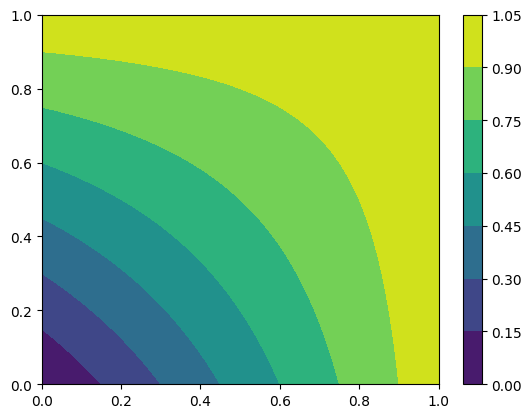

1.0

In [345]:
# check function works with contour plot
import matplotlib.pyplot as plt
import numpy as np

def plot_contour(x, y, values):
    X, Y = np.meshgrid(x, y)
    plt.contourf(X, Y, values)
    plt.colorbar()
    plt.show()


x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)

X, Y = np.meshgrid(x, y)
values = [[union_prob([x_i,y_i]) for y_i in y] for x_i in x]
plot_contour(x,y,values)
# looks correct!